<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/00_WhiteNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 백색잡음(white noise)

White noise: n=1000, sample mean=-0.0289, sample var=0.9786


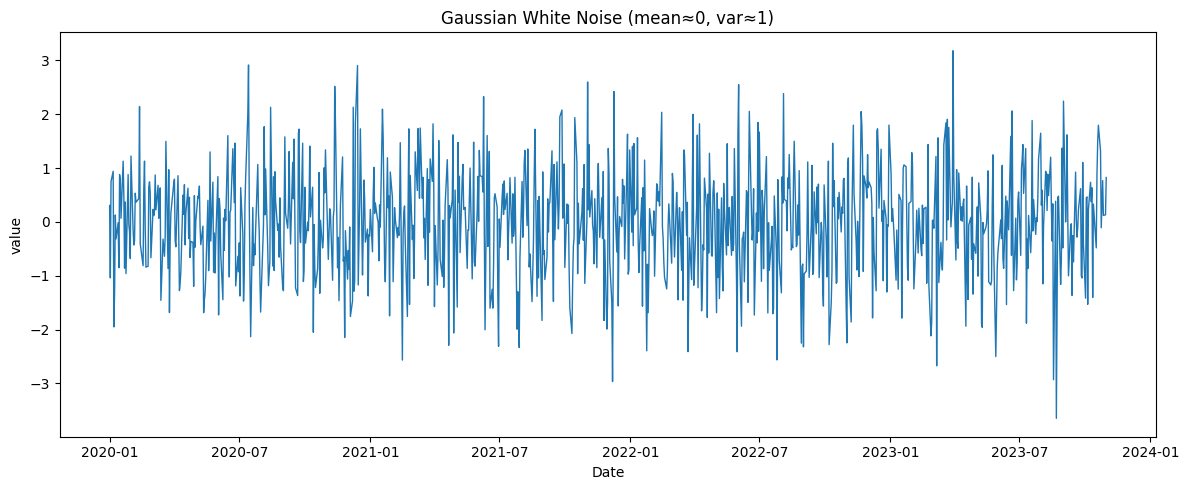

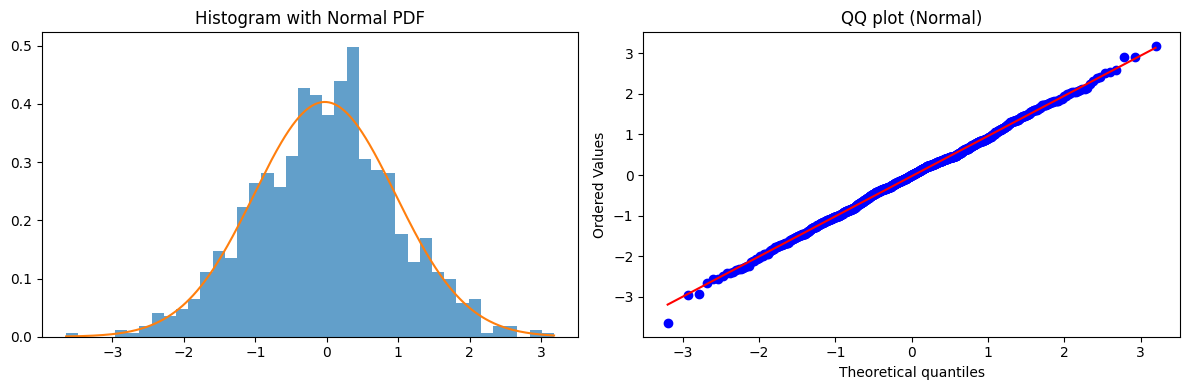

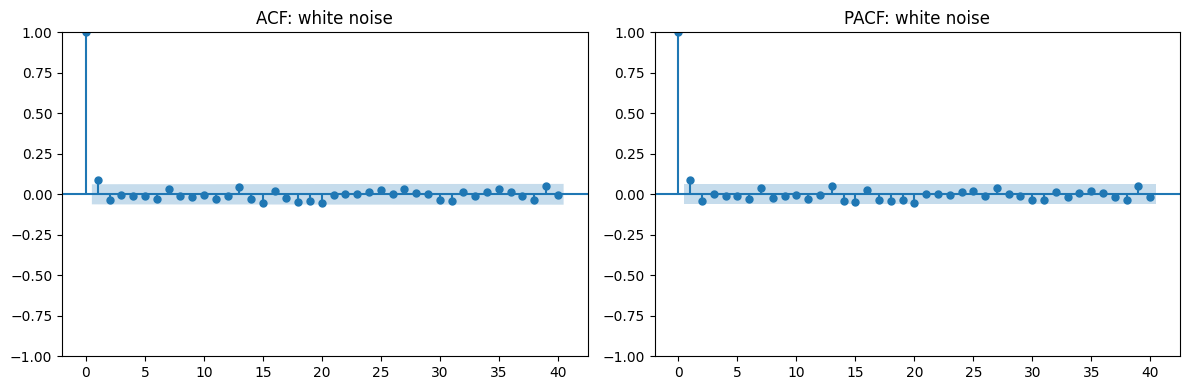


[Ljung–Box] white noise
     LB stat  p-value
lag                  
10   11.3872   0.3282
20   26.6883   0.1443
40   38.0066   0.5603
  lag=10 → p=0.3282 → Fail to reject H0 (no autocorr)
  lag=20 → p=0.1443 → Fail to reject H0 (no autocorr)
  lag=40 → p=0.5603 → Fail to reject H0 (no autocorr)


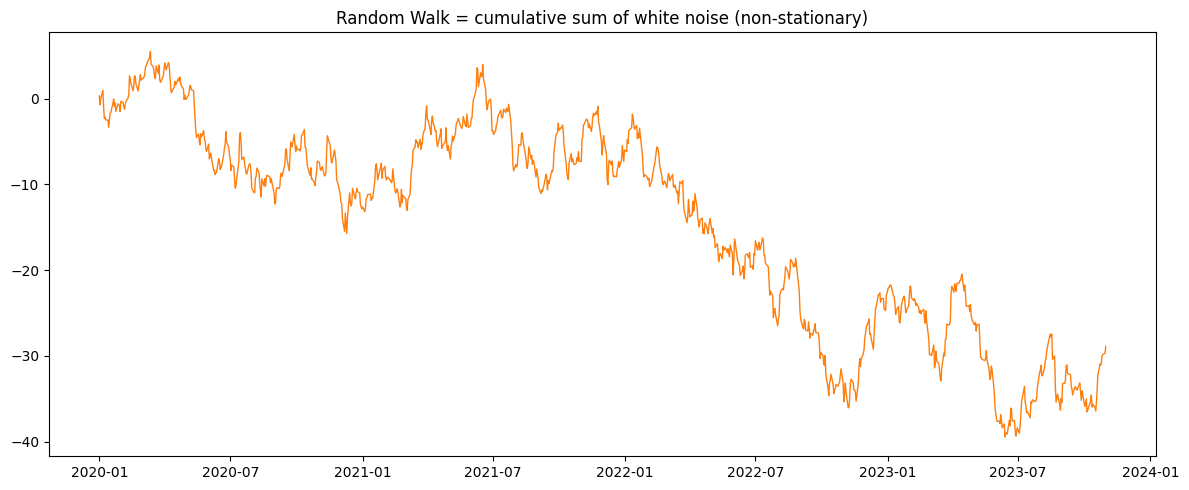

[*********************100%***********************]  1 of 1 completed



TSLA: 2018-01-02 ~ 2025-10-08 | 1953 prices, 1952 returns


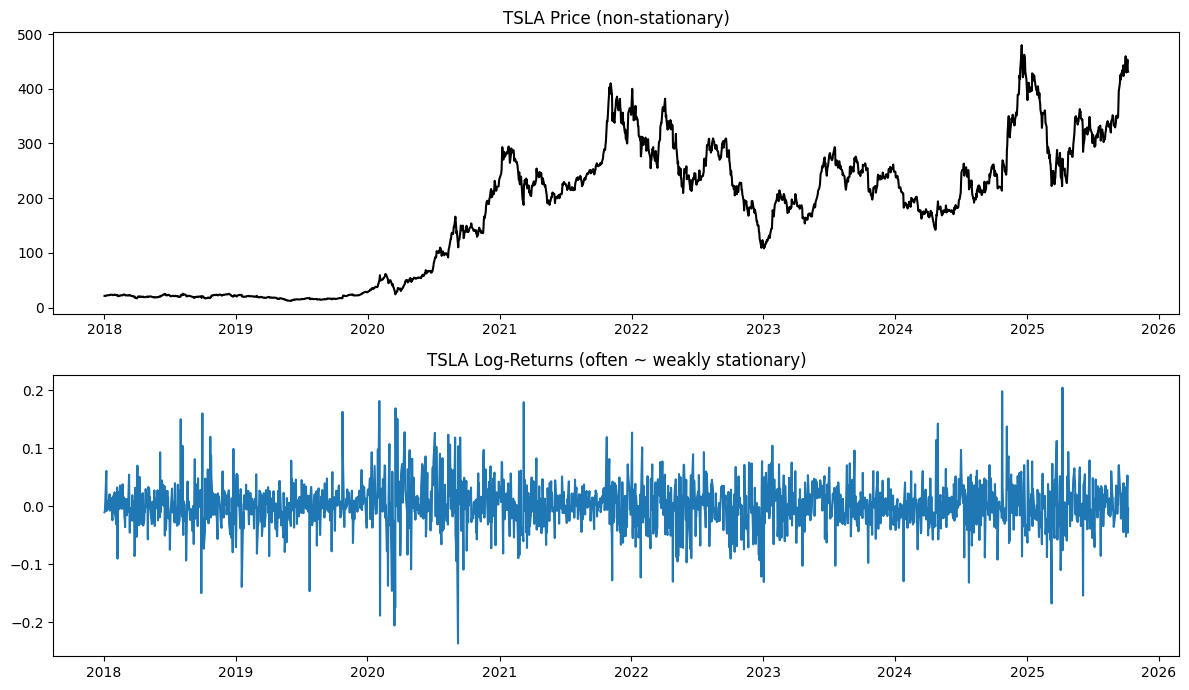

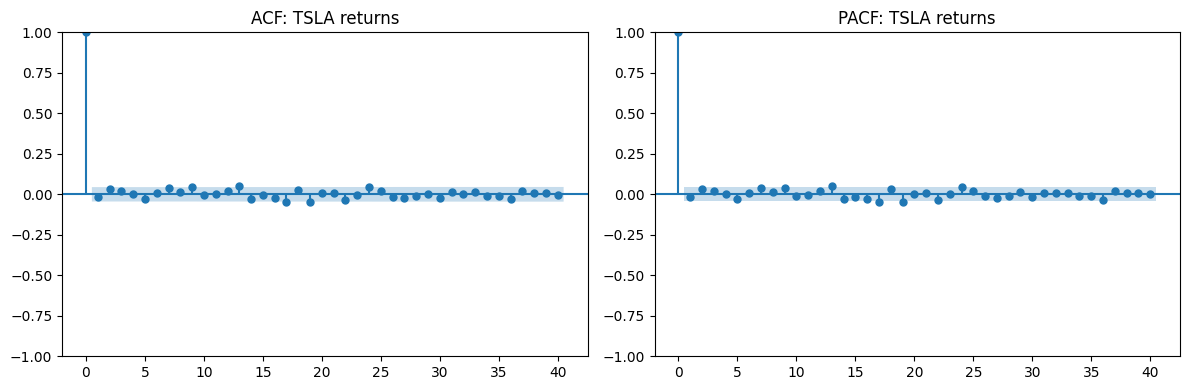


[Ljung–Box] TSLA log-returns
     LB stat  p-value
lag                  
10   11.5179   0.3186
20   31.9102   0.0443
40   45.9229   0.2401
  lag=10 → p=0.3186 → Fail to reject H0 (no autocorr)
  lag=20 → p=0.0443 → Reject H0 (autocorr exists)
  lag=40 → p=0.2401 → Fail to reject H0 (no autocorr)


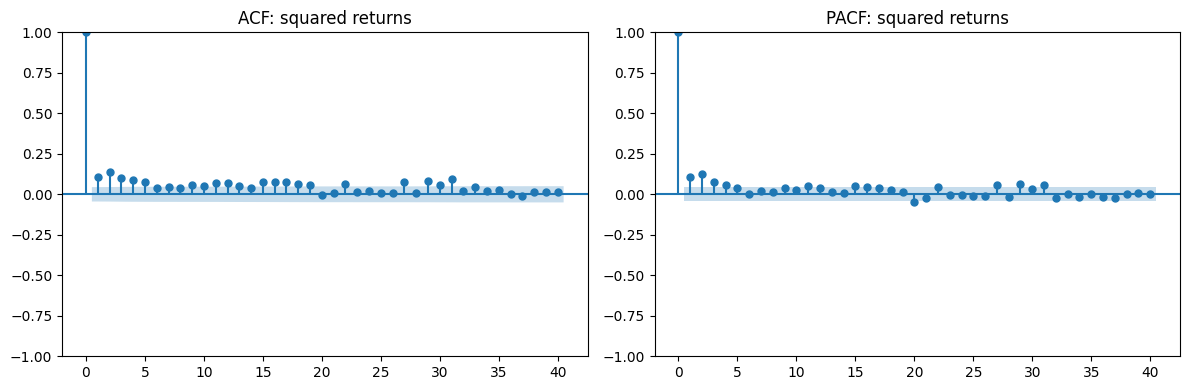


[Ljung–Box] (TSLA returns)^2
     LB stat  p-value
lag                  
10  125.1597   0.0000
20  202.1468   0.0000
40  270.5743   0.0000
  lag=10 → p=0.0000 → Reject H0 (autocorr exists)
  lag=20 → p=0.0000 → Reject H0 (autocorr exists)
  lag=40 → p=0.0000 → Reject H0 (autocorr exists)


,LB stat,p-value
lag,,
10,125.159713,4.525206e-22
20,202.146797,4.230600e-32
40,270.574325,5.241303e-36


In [4]:
# =========================================================
# White Noise demo + (reference) TSLA log-returns  (fixed)
# =========================================================
# %pip -q install yfinance statsmodels scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

plt.rcParams["figure.figsize"] = (12, 5)

# ----------------------------------
# 0) Helper: Ljung–Box reporting
# ----------------------------------
def lb_report(x, lags=(10, 20, 40), alpha=0.05, name="series"):
    x = pd.Series(x).dropna()
    out = acorr_ljungbox(x, lags=list(lags), return_df=True)
    res = out[["lb_stat", "lb_pvalue"]].rename(columns={"lb_stat":"LB stat", "lb_pvalue":"p-value"})
    res.index.name = "lag"
    print(f"\n[Ljung–Box] {name}")
    print(res.to_string(float_format=lambda v: f"{v:,.4f}"))
    for lag, p in zip(res.index, res["p-value"]):
        decision = "Fail to reject H0 (no autocorr)" if p >= alpha else "Reject H0 (autocorr exists)"
        print(f"  lag={lag:>2} → p={p:.4f} → {decision}")
    return res

# =========================================================
# 1) Simulated WHITE NOISE  (Gaussian white noise)
# =========================================================
rng = np.random.default_rng(42)
n = 1_000
sigma = 1.0

eps = rng.normal(loc=0.0, scale=sigma, size=n)
idx  = pd.date_range("2020-01-01", periods=n, freq="B")
wn   = pd.Series(eps, index=idx, name="white_noise")

print(f"White noise: n={len(wn)}, sample mean={wn.mean():.4f}, sample var={wn.var(ddof=1):.4f}")

# --- Time series plot
plt.figure()
plt.plot(wn.index, wn.values, lw=1)
plt.title("Gaussian White Noise (mean≈0, var≈1)")
plt.xlabel("Date"); plt.ylabel("value"); plt.tight_layout(); plt.show()

# --- Histogram + normal fit + QQ plot
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(wn, bins=40, density=True, alpha=0.7)
xgrid = np.linspace(wn.min(), wn.max(), 400)
ax[0].plot(xgrid, stats.norm.pdf(xgrid, wn.mean(), wn.std(ddof=1)))
ax[0].set_title("Histogram with Normal PDF")

stats.probplot(wn, dist="norm", plot=ax[1])
ax[1].set_title("QQ plot (Normal)")
plt.tight_layout(); plt.show()

# --- ACF / PACF
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(wn, lags=40, ax=ax[0]); ax[0].set_title("ACF: white noise")
plot_pacf(wn, lags=40, ax=ax[1], method="ywm"); ax[1].set_title("PACF: white noise")
plt.tight_layout(); plt.show()

# --- Ljung–Box (should NOT reject H0 for true white noise)
lb_report(wn, lags=(10, 20, 40), name="white noise")

# (참고) 누적합은 '랜덤워크' → 비정상
rw = wn.cumsum()
plt.figure()
plt.plot(rw, lw=1, color="tab:orange")
plt.title("Random Walk = cumulative sum of white noise (non-stationary)")
plt.tight_layout(); plt.show()

# =========================================================
# 2) Reference: TSLA daily LOG-RETURNS (approx white noise?)
# =========================================================
symbol = "TSLA"
px = yf.download(symbol, start="2018-01-01", auto_adjust=True)[["Close"]].dropna()
px.index = pd.to_datetime(px.index)

# 반드시 Series로 만들고 이름 지정
price = px.squeeze("columns").astype(float)
price.name = "price"

# rename(...) 쓰지 말고 name 속성으로 지정
ret = np.log(price).diff().dropna()
ret.name = "log_return"

print(f"\nTSLA: {price.index[0].date()} ~ {price.index[-1].date()} | "
      f"{len(price)} prices, {len(ret)} returns")

# --- Time series (price vs returns)
fig, ax = plt.subplots(2, 1, figsize=(12,7), sharex=False)
ax[0].plot(price, color="black"); ax[0].set_title("TSLA Price (non-stationary)")
ax[1].plot(ret, color="tab:blue"); ax[1].set_title("TSLA Log-Returns (often ~ weakly stationary)")
plt.tight_layout(); plt.show()

# --- ACF/PACF of returns
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(ret, lags=40, ax=ax[0]); ax[0].set_title("ACF: TSLA returns")
plot_pacf(ret, lags=40, ax=ax[1], method="ywm"); ax[1].set_title("PACF: TSLA returns")
plt.tight_layout(); plt.show()

# --- Ljung–Box on returns
lb_report(ret, lags=(10, 20, 40), name="TSLA log-returns")

# --- (Optional) squared returns: volatility clustering check
fig, ax = plt.subplots(1, 2, figsize=(12,4))
plot_acf(ret**2, lags=40, ax=ax[0]); ax[0].set_title("ACF: squared returns")
plot_pacf(ret**2, lags=40, ax=ax[1], method="ywm"); ax[1].set_title("PACF: squared returns")
plt.tight_layout(); plt.show()

lb_report(ret**2, lags=(10, 20, 40), name="(TSLA returns)^2")
